In [18]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit as cf
plt.rcParams['figure.figsize'] = (20,8)

import warnings
warnings.filterwarnings('ignore')

In [19]:
a1 = basis(5,0)
a2 = basis(5,1)
b1 = basis(5,2)
b2 = basis(5,3)
c = basis(5,4)

In [20]:
def find_idx(arr, val):
    return np.argmin(np.abs(arr-val))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)


def pulse(t, risetime, pulsewidth, t0):
    return np.where(t<pulsewidth/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+pulsewidth))


def seqC3(t, args): 
    tstart = args['tstart']
    pulsewidth = args['pulsewidth']
    return np.where(t<pulsewidth/2+tstart, sigmoid(t,0.86,4+tstart),1-sigmoid(t,0.86,pulsewidth+2+tstart))

In [197]:
def RamanDynamics(t, delta, Delta, OmegaC1, OmegaC3, pulse_seq_C1, pulse_seq_C3):
    HintC1 = OmegaC1/2*(a1*c.dag() + c*a1.dag()) 
    HintC3 = OmegaC3/2*(a2*c.dag() + c*a2.dag())

    # Delta = omega_2 - (omega_13-omega_23), delta = omega_3-omega_13
    Hsys = Delta*a2*a2.dag() + delta*c*c.dag()
    H = [Hsys, [HintC1, pulse_seq_C1], [HintC3, pulse_seq_C3]]

    rho0 = steadystate(Hsys, c_ops)

    # print("Initial populations", [round(abs(rho0[i,i]),2) for i in range(rho0.shape[0])])
    e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c*c.dag()]
    
    output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops)
    
    return rho0, output

def plotDynamics(t, output):
    cts = output.expect[4]
    
    fig, axs = plt.subplots(5, figsize=(20,8))
    # try:
    #     p0 = \
    #         (
    #             np.amax(cts_fit), 
    #             Omega_R, 
    #             Gamma_opt, 
    #             0, 
    #             np.mean(cts_fit), 
    #             np.mean(cts_fit)/(t_fit[-1]-t_fit[0]), 
    #             cts_fit[-1]
    #         )
    #     ramsey_fit = lambda t, a, Omega, Gamma, phi, b, c, d: a*np.exp(-Gamma*t)*np.sin(Omega*t+phi) + b*np.exp(-c*t) + d
    #     popt, pcov = cf(ramsey_fit, t_fit-t_fit[0], cts_fit, p0=p0)

    #     print(OmegaC1, OmegaC3, Gamma_pht, Omega_R, Gamma_opt)
    #     print(popt[1], popt[2])

    #     # axs[0].plot(t_fit-t_fit[0], cts_fit, '--k', label='Fit')
    #     # axs[0].plot(t_fit, ramsey_fit(t_fit-t_fit[0], *popt), '--k', label='Fit')
    #     # axs[0].legend()
    # except Exception:
    #     print("No fit possible")
    
    axs[0].plot(t, output.expect[-1], label=f'c ({delta})', color='r')
    axs[0].legend()

    axs[1].plot(t, output.expect[0], color='b')
    axs[1].set_ylabel(f'a1 ({delta})')
    axs[1].twinx().plot(t, output.expect[1], color='k')
    axs[1].twinx().set_ylabel(f'a2 ({delta})')
    
    axs[2].plot(t, output.expect[2], color='g')
    axs[2].set_ylabel(f'b1 ({delta})')
    axs[2].twinx().plot(t, output.expect[3], color='y')
    axs[2].twinx().set_ylabel(f'b2 ({delta})')
    

    axs[3].plot(t, pulse_seq_C1)
    axs[4].plot(t, pulse_seq_C3)
    plt.tight_layout()

In [287]:
h = 6.626e-34
kB = 1.38e-23
T = 8
gs = 63e9
boltzmann = np.exp(-h*gs/(kB*T))

eta = 0.25
Gamma_pht = 1/(2*np.pi*1.7)
Gamma_phn = 1/(2*np.pi*50)
Gamma_spin = 1/(2*np.pi*200)

Gamma_c = np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2)*c.dag()

Gamma_a1 = (np.sqrt(Gamma_spin)*a2 + (np.sqrt(eta*boltzmann*Gamma_phn)*b2 + np.sqrt(boltzmann*Gamma_phn)*b1))*a1.dag()
Gamma_a2 = (np.sqrt(Gamma_spin)*a1 + (np.sqrt(eta*boltzmann*Gamma_phn)*b1 + np.sqrt(boltzmann*Gamma_phn)*b2))*a2.dag()

Gamma_b1 = (np.sqrt(Gamma_spin)*b2+(np.sqrt(eta*Gamma_phn)*a2 + np.sqrt(Gamma_phn)*a1))*b1.dag()
Gamma_b2 = (np.sqrt(Gamma_spin)*b1+(np.sqrt(eta*Gamma_phn)*a1 + np.sqrt(Gamma_phn)*a2))*b2.dag()

# Gamma_pure_deph = np.sqrt(Gamma_deph)*(a2*a2.dag()-a1*a1.dag()+b2*b2.dag()-b1*b1.dag())

c_ops = [Gamma_c, Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2]

0.3057765288826444


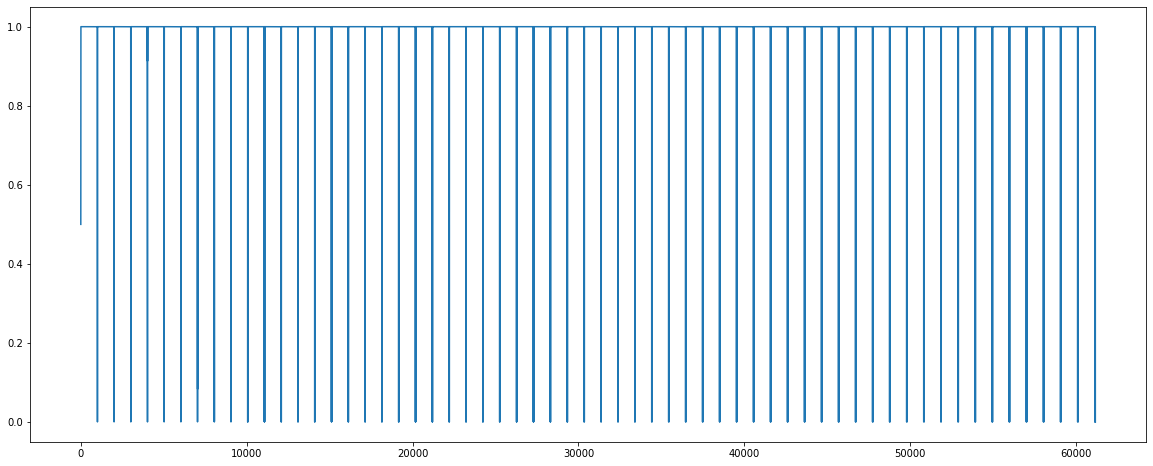

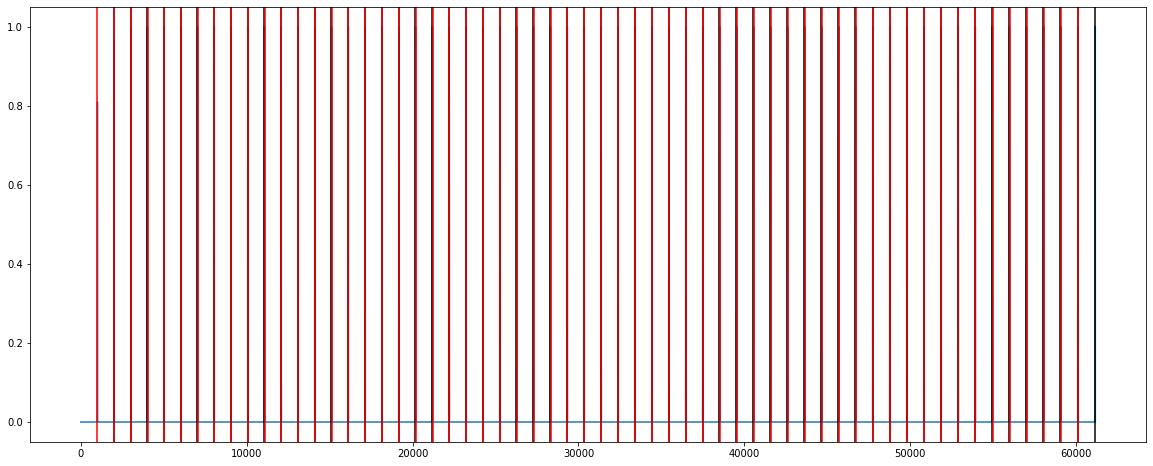

In [296]:
risetime = 1
pulsewidth_init = 1000
pulsewidth_read = 500

pulsewidth_start = 0.5
pulsewidth_incr = 0.5
num_pulses = 60

pulsewidths = np.arange(0, (num_pulses)*pulsewidth_incr, pulsewidth_incr) + pulsewidth_start
t = np.linspace(0,len(pulsewidths)*(pulsewidth_init+4*risetime)+np.sum(pulsewidths), 500000)
print(t[1]-t[0])

pulse_seq_C1 = np.zeros(len(t))
pulse_seq_C3 = np.zeros(len(t))

tstart = 0
read_starts = []
read_stops = []
for pulsewidth in pulsewidths:
      
    read_starts.append(tstart+risetime) 
    pulse_seq_C1 += pulse(t, risetime, pulsewidth_init, tstart)
    read_stops.append(tstart+pulsewidth_init-risetime)  
    tstart += pulsewidth_init + 2*risetime

    pulse_seq_C1 += pulse(t, risetime, pulsewidth, tstart)
    pulse_seq_C3 += pulse(t, risetime, pulsewidth, tstart)
    tstart += pulsewidth + 2*risetime
    

plt.plot(t, pulse_seq_C1)
plt.show()
plt.plot(t, pulse_seq_C3)
for i in range(1,num_pulses):
    plt.axvline(read_starts[i], color='r')
    plt.axvline(read_stops[i], color='k')

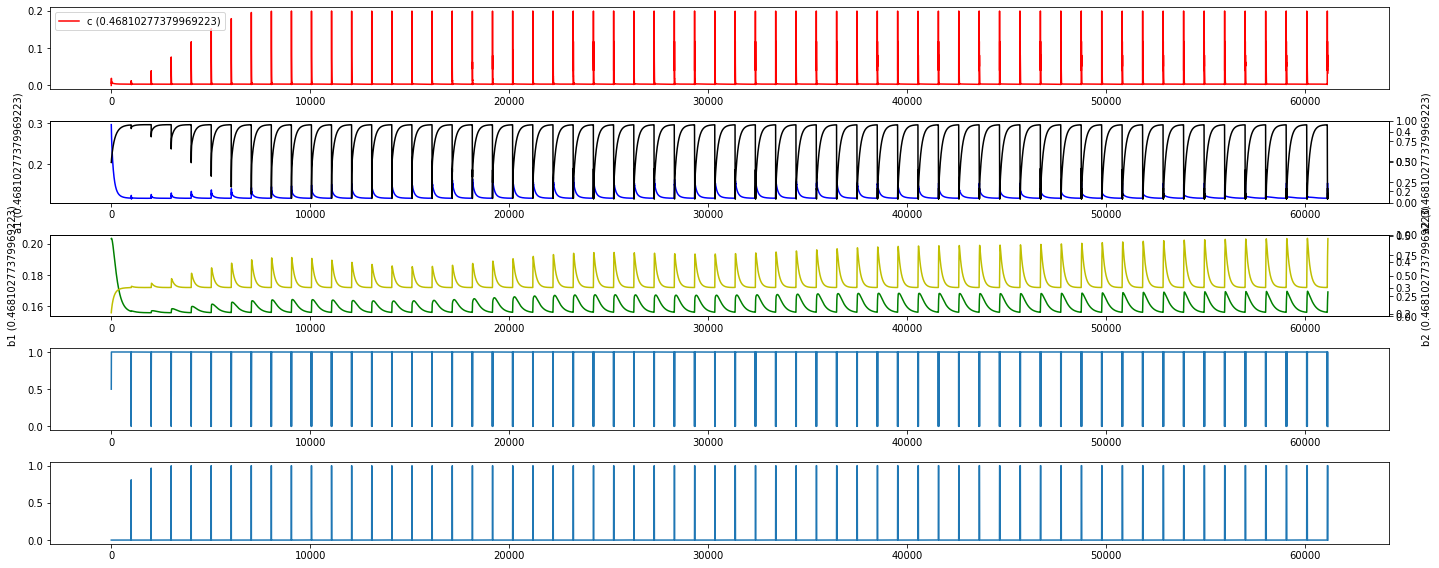

In [297]:
for delta in np.array([5]):
    delta = delta*Gamma_pht
    Delta = 0

    sat = 100
    IsatC3 = 10
    IsatC1 = IsatC3*eta
    IC3 = sat * IsatC3
    IC1 = sat * IsatC1
    OmegaC3 = np.sqrt(IC3/(2*IsatC3))*Gamma_pht
    OmegaC1 = np.sqrt(IC1/(2*IsatC1))*Gamma_pht*eta
    Omega_R = OmegaC1*OmegaC3/(2*delta) if delta!=0 else min(OmegaC1, OmegaC3)
    Gamma_opt = Gamma_pht*OmegaC1*OmegaC3/(4*delta**2) if delta!=0 else min(OmegaC1, OmegaC3)

    rho0, output = RamanDynamics(t, delta, Delta, OmegaC1, OmegaC3, pulse_seq_C1, pulse_seq_C3)
    plotDynamics(t, output)

No fit possible


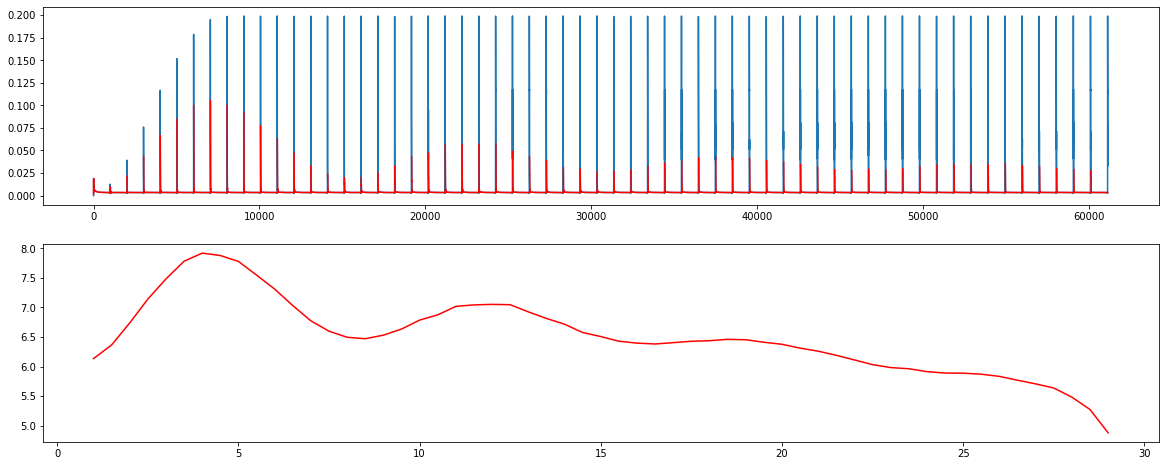

In [303]:
cts = output.expect[-1]
peak_heights = []
fig, axs = plt.subplots(2)
axs[0].plot(t, cts)
for i in range(num_pulses):
    idx_read_start = find_idx(t, read_starts[i])
    idx_read_stop = find_idx(t, read_stops[i])
    axs[0].plot(t[idx_read_start:idx_read_stop], cts[idx_read_start:idx_read_stop], c='r')
    
    peak_heights.append(np.sum(cts[idx_read_start:idx_read_stop])-(t[idx_read_stop]-t[idx_read_start])*np.mean(cts[idx_read_stop-5:]))

taus = pulsewidths[1:]
cts_taus = peak_heights[1:]
axs[1].plot(taus[:-2], cts_taus[:-2], '-r')

try:
    p0 = \
        (
            np.amax(cts_taus), 
            Omega_R, 
            Gamma_opt, 
            0, 
            np.mean(cts_taus), 
            np.mean(cts_taus)/(taus[-1]-taus[0]), 
            cts_taus[-1]
        )
    ramsey_fit = lambda t, a, Omega, Gamma, phi, b, c, d: a*np.exp(-Gamma*t)*np.sin(Omega*t+phi) + b*np.exp(-c*t) + d
    popt, pcov = cf(ramsey_fit, taus, cts_taus, p0=p0)

    print(popt[1], popt[2])
    axs[1].plot(taus, ramsey_fit(taus, *popt), '-.k')
except Exception:
    print("No fit possible")

